# State of the Business Analysis

## Case Description

You are a BA working for a startup that has one credit product called **Contigo**. Depending on risk, the customer will receive:
1. Contigo A, a 1,000 peso loan to be paid in full after one month with 15% interest. This product is given to high risk customers.
2. Contigo B, a 2,000 peso loan to be paid in full after one month with 10% interest. This product is given to low risk customers.

Past debt delinquency (DQ) rates have determined the interest rates for the Contigo product. However, it is estimated that the monthly DQ rate for Contigo A will be 13.5% and 8% for Contigo B, throughout this year.

Ignoring the worsening of DQ rates, this startup has an ambitious growth plan for the year. At month 1,
the company had a total of 5,000 Contigo A customers, expected to grow at a rate of 25% month over
month. Contigo B has the largest share of customers, 10,000 in total. But with a very competitive market
for premium loans, Contigo B is expected to grow at a 10% month over month rate throughout the year.

The operation of this startup scales proportionately to its customer base, with negligible fixed expenses. The current operative monthly cost per account sits at 30 pesos.

The startup is concerned that the change in DQ rates and the aggressive expansion may reduce profitability in the following months, so they asked you to make a forecast on the net income of its operation (ignoring taxes) in the next 12 months.

### Loan Types Diagram

<img 
    src="https://i.imgur.com/B7NvEKb.png"
    height=300
    width=500
/>

## Case Analysis

The following sections shows the calculations that were done on every step to forecast the net income during the next 12 months.

In [321]:
# Import required libraries and modules
import numpy as np
import math
import pandas as pd
import plotly.express as px

The `contigo_a_features` and `contigo_b_features` are Python dictionaries that store all the features for Contigo A and B, respectively. By modifying theses features the user can run the whole notebook and see the changes on the net income.

In [322]:
# Contigo A loan features
contigo_a_features = {
    "loan_amt":1000,
    "loan_term":1,
    "interest_rate":0.135*(1+0.42),
    "delinquency_rate":0.135,
    "initial_num_accounts":5000,
    "account_growth_mom":0.25,
    "op_cost_per_acct":30
}

# Contigo B loan features
contigo_b_features = {
    "loan_amt":2000,
    "loan_term":1,
    "interest_rate":0.08*(1+0.3),
    "delinquency_rate":0.08,
    "initial_num_accounts":10000,
    "account_growth_mom":0.10,
    "op_cost_per_acct":30
}

Where:

- **loan_amt**: The loan amount in mexican pesos.
- **loan_term**: The number of months to pay the loan amount in full.
- **interest_rate**: The monthly interest rate.
- **delinquency_rate**: The monthly estimated delinquency rate throughout the year.
- **initial_num_accounts**: The number of accounts/customers for the first month.
- **account_growth_mom**: The estimated growth rate for the accounts month-over-month.
- **op_cost_per_acct**: The current operative monthly cost per account in mexican pesos.

### Step 1: Calculating Accounts

The following function simplifies the calculations to get the total number of accounts for each month during the next 12 months. 

It uses `math.floor` to round down the accounts to the nearest whole number because the number of accounts is a **discrete variable**.

> **Note**: The goal of using this function is to reduce the amount of lines of codes.

In [323]:
def compute_accounts(initial_accounts: int, growth_rate: float, num_months=12):
    """Computes the number of accounts by each month during a period of 12 months given a MoM growth rate"""
    return [math.floor(initial_accounts * (1+ growth_rate) ** i) for i in range(num_months)]    

The total number of accounts for Contigo A and B are stored as **numpy** arrays to allow for **element-wise operations**.

In [324]:
# Number of accounts month-over-month of Contigo A
contigo_a_accounts_mom = \
    np.array(compute_accounts(contigo_a_features["initial_num_accounts"], contigo_a_features["account_growth_mom"]))

# Number of accounts month-over-month of Contigo B
contigo_b_accounts_mom = \
    np.array(compute_accounts(contigo_b_features["initial_num_accounts"], contigo_b_features["account_growth_mom"]))

### Step 2: Claculating Delinquency Accounts

The number of delinquency accounts are calculated by multiplying the number of accounts of each month by the delinquency rate.

The delinquency accounts represent the number of accounts whose payments were not made.

**Formula**:
$$DelinquencyAccounts = NumberOfAccounts \times DelinquencyRate$$

In [325]:
# Number of delinquency accounts month-over-month of Contigo A
contigo_a_delinq_accts_mom = contigo_a_accounts_mom * contigo_a_features["delinquency_rate"]

# Round down every element in the array to the nearest whole number
contigo_a_delinq_accts_mom = np.floor(contigo_a_delinq_accts_mom)

# Number of delinquency accounts month-over-month of Contigo B
contigo_b_delinq_accts_mom = contigo_b_accounts_mom * contigo_b_features["delinquency_rate"]

# Round down every element in the array to the nearest whole number
contigo_b_delinq_accts_mom = np.floor(contigo_b_delinq_accts_mom)

### Step 3: Interest Revenue

In this step a function is defined to first calculate the interest revenue **per account** (without considering the customers whose payments were not made), and then multiplies this value by each number of accounts on every month.

The interest revenue represent the amount of interests that were collected from the customers whose payments were made.

**Formula**:
$$InterestRevenuePerAccount = LoanAmount \times InterestRate \times LoanTerm \times (1 - DelinquencyRate)$$

$$TotalInterestRevenue = NumberOfAccounts \times InterestRevenuePerAccount$$

> **Note**: The goal of using this function is to reduce the amount of lines of codes.

In [326]:
def compute_interest_rev(loan_feats: dict, loan_accounts_mom):
    """Computes the interest revenue by each month during a period of 12 months"""
    interest_revenue_per_account = \
        loan_feats["loan_amt"]*loan_feats["interest_rate"]*loan_feats["loan_term"]*(1-loan_feats["delinquency_rate"])
    return loan_accounts_mom * interest_revenue_per_account

In [327]:
# Interest revenue month-over-month of Contigo A
contigo_a_interest_rev_mom = compute_interest_rev(contigo_a_features, contigo_a_accounts_mom)

# Interest revenue month-over-month of Contigo B
contigo_b_interest_rev_mom = compute_interest_rev(contigo_b_features, contigo_b_accounts_mom)

### Step 4: Delinquency Losses

The delinquency losses are calculated by multiplying the number of delinquent accounts per month by the loan amount.

The delinquency loss represents the loan amount that was uncollected during the month.

**Formula**:
$$DelinquencyLoss = DelinquentAccounts \times LoanAmount$$

In [328]:
# Delinquency loss month-over-month of Contigo A
contigo_a_delinq_loss_mom = contigo_a_delinq_accts_mom * contigo_a_features["loan_amt"]

# Delinquency loss month-over-month of Contigo B
contigo_b_delinq_loss_mom = contigo_b_delinq_accts_mom * contigo_b_features["loan_amt"]

### Step 5: Operative Cost

The operative cost is calculated by multiplying the number of accounts of each month by the operating cost of the loan product.

The operative cost for this startup represents the expenses incurred to maintain the loan accounts.

**Formula**:
$$OperativeCost = TotalAccounts \times CostPerAccount$$

In [329]:
# Operative cost month-over-month of Contigo A
contigo_a_op_cost_mom = contigo_a_accounts_mom * contigo_a_features["op_cost_per_acct"]

# Operative cost month-over-month of Contigo B
contigo_b_op_cost_mom = contigo_b_accounts_mom * contigo_b_features["op_cost_per_acct"]

### Step 6: Net Income

The net income is calculated by subtracting the total operative costs and delinquency losses from the interest collected from customers whose payments were made.

For this startup, the net income represents the amount of money that the startup has after paying all of its costs and expenses but before paying taxes.

**Formula**:

$$NetIncome = InterestRevenue - OperativeCost - DelinquencyLoss$$

In [330]:
# Net income month-over-month of Contigo A
contigo_a_net_income_mom = contigo_a_interest_rev_mom - contigo_a_op_cost_mom - contigo_a_delinq_loss_mom

# Net income month-over-month of Contigo B
contigo_b_net_income_mom = contigo_b_interest_rev_mom - contigo_b_op_cost_mom - contigo_b_delinq_loss_mom

### Step 7: Showing Results in Tabular Format

In this step all of the previous variables are used to create a table by using pandas `DataFrame`.

In [331]:
# Maps column names to values
cols_to_values = {
    "month":np.concatenate((np.arange(1,13), np.arange(1,13))),
    "loan_type":["Contigo A"] * 12 + ["Contigo B"] * 12,
    "accounts":np.concatenate((contigo_a_accounts_mom, contigo_b_accounts_mom)),
    "delinquency_accounts":np.concatenate((contigo_a_delinq_accts_mom, contigo_b_delinq_accts_mom)),
    "interest_revenue":np.concatenate((contigo_a_interest_rev_mom, contigo_b_interest_rev_mom)),
    "delinquency_loss":np.concatenate((contigo_a_delinq_loss_mom, contigo_b_delinq_loss_mom)),
    "operative_costs":np.concatenate((contigo_a_op_cost_mom, contigo_b_op_cost_mom)),
    "net_income":np.concatenate((contigo_a_net_income_mom, contigo_b_net_income_mom))
}

# Creates a DataFrame with the results of Contigo loans
collection_results = pd.DataFrame(cols_to_values)

# Converts loan type column to a categorical data type
collection_results["loan_type"] = pd.Categorical(collection_results.loan_type)

# Converts delinquency accounts to an integer data type
collection_results["delinquency_accounts"] = collection_results.delinquency_accounts.astype("int")

In [332]:
collection_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   month                 24 non-null     int64   
 1   loan_type             24 non-null     category
 2   accounts              24 non-null     int64   
 3   delinquency_accounts  24 non-null     int64   
 4   interest_revenue      24 non-null     float64 
 5   delinquency_loss      24 non-null     float64 
 6   operative_costs       24 non-null     int64   
 7   net_income            24 non-null     float64 
dtypes: category(1), float64(3), int64(4)
memory usage: 1.6 KB


### Step 8: Exporting Results

In this step the previous table is exported to a `.csv` file in case the user needs to share the results.

In [333]:
# Export results to a CSV file
collection_results.to_csv("./collection_results.csv", index=False)

### Step 9: Analyzing Results

In [334]:
collection_results.groupby("loan_type").interest_revenue.sum()

loan_type
Contigo A    4.494283e+07
Contigo B    4.092042e+07
Name: interest_revenue, dtype: float64

In [335]:
print(f"""
    Interest Revenue:       ${collection_results.interest_revenue.sum()}
(-) Operative Costs:        ${collection_results.operative_costs.sum()}
(-) Delinquency Losses:     ${collection_results.delinquency_loss.sum()}
------------------------------------------
    Net Income:             ${collection_results.net_income.sum()}
""")


    Interest Revenue:       $85863249.97650002
(-) Operative Costs:        $14546190
(-) Delinquency Losses:     $70787000.0
------------------------------------------
    Net Income:             $530059.976500014



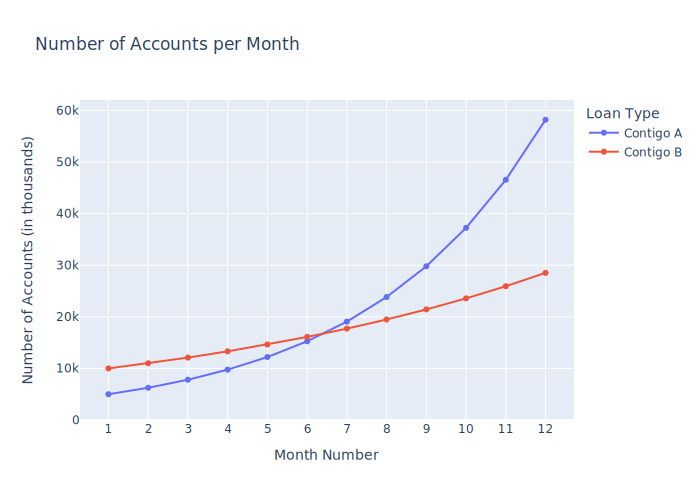

In [336]:
accts_lin_plot = px.line(collection_results,
                         x="month",
                         y="accounts",
                         color="loan_type",
                         markers=True,
                         title="Number of Accounts per Month")

# Update figure layout
accts_lin_plot.update_layout(xaxis_title="Month Number",
                             yaxis_title="Number of Accounts (in thousands)",
                             legend_title="Loan Type")

# Set y-axis to start at 0
accts_lin_plot.update_yaxes(rangemode="tozero")

# Set the steps between ticks to 1
accts_lin_plot.update_xaxes(dtick=1)

# Show figure in svg format
accts_lin_plot.show("svg")

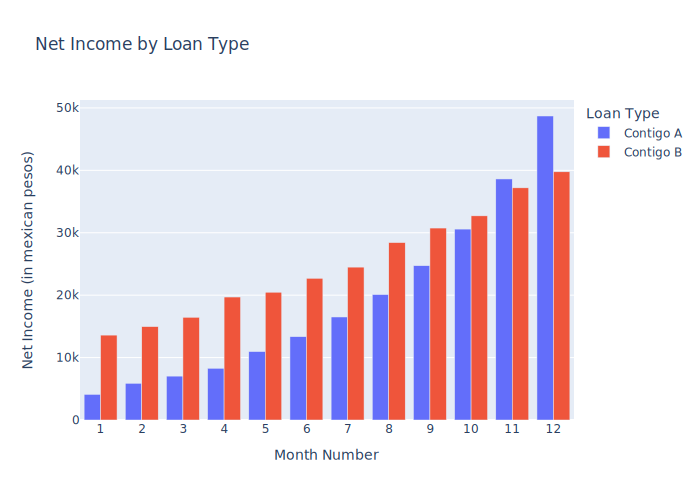

In [337]:
gross_income_barplot = px.bar(collection_results,
                               x="month",
                               y="net_income",
                               color="loan_type",
                               barmode="group",
                               title="Net Income by Loan Type")

# Update figure layout
gross_income_barplot.update_layout(xaxis_title="Month Number",
                             yaxis_title="Net Income (in mexican pesos)",
                             legend_title="Loan Type")

# Set the steps between ticks to 1
gross_income_barplot.update_xaxes(dtick=1)

# Show figure in svg format
gross_income_barplot.show("svg")

> **Note**: The y-axis of the previous plot abbreviates millions as "M" and thousands as "K".

## Questions

> **Question 1**: What factors may be against the profitability of the startup? What should we look at in an analysis of the net income for the following months?

### Factors Against Profitability

1. Given that delinquency rates determine the interest rate of Contigo's products, if **delinquency rates are higher than interest rates** the startup would have a **negative gross margin** due to a lower amount of interests collected every month. This scenario would lead to a decrease in the profitability.

2. An **increase in operating costs per account** could also decrease the profitability of the startup. Some examples are: 
    - Spending too much on collection efforts: Using unnecesarry or expensive communication channels with customers.
    
    - A higher inflation that leads an increase in the prices of the software that is required to maintain the software for account management.

3. An **increase in the reference rate by the Central Bank** could increase the probability of more customers not paying on time, raising delinquency rates of Contigo's products. If the the reference rate raise is significant or happens too fast, delinquency rates could grow at a higher pace than the interest rates of Contigo's products.

### Look Up for Following Months
1. At first hand, the startup should never allow to have lower interest rates for products that are riskier. 

2. They should also track the growth rates of delinquency and interest rates, trying to keep a lower growth in delinquency rates than interest rates. 

3. Last but not least, the startup should focus on a strategy to diversify the income, to relative frequency of interest income.

> **Question 2**: Is this startup going to be profitable during the next 12 months? What are the major trends driving changes in net income? 
>
> Provide a model for net income and forecast it for the next 12 months. 
>> **Note**: Consider that losses come from the total debt not being repaid, and revenue comes from collected interest. We will only consider operation costs as expenses.

> **Question 3**: What changes are required to sustain the business not only throughout the year but in the long run?
>
> Build a proposal of changes to main startup KPIs to achieve this goal. Discuss what difficulties the startup may find in applying your recommendation.

KPI:
- Interest-to-delinquency: 

    * $\frac {InterestRate}{DelinquencyRate} \ge 1.42$ for Contigo A

    * $\frac {InterestRate}{DelinquencyRate} \ge 1.30$ for Contigo B